In [1]:
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# save numpy array as csv file
from numpy import savetxt
# define data
# save to csv file
import json
import contractions
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import spacy
from collections import Counter, defaultdict
from xgboost import XGBClassifier




# Obtenir le répertoire de travail courant (dans un notebook, par exemple)
current_dir = os.getcwd()
nlp = spacy.load("en_core_web_sm")

#print("Current working directory: {0}".format(current_dir))

exec(open(os.path.join(current_dir, "functions.py")).read())



## Résumé


## Description des données 

Le jeu de données ACL IMDB (souvent appelé aussi aclImdb ou IMDB Movie Reviews) est un jeu de 50 000 critiques de films recueillies sur le site IMDB, spécialement conçu pour la classification de sentiment (positif/négatif). Il a été introduit dans l’article de Andrew L. Maas et al. (2011), Learning Word Vectors for Sentiment Analysis. 

La première étape de l'analyse consiste à charger ces données, les explorer et les prétraiter. Dans la cellule suivante, les données train négatives sont chargées. La fonction `input_docs`permet de charger les données. Elle utilise les expressions régulières pour supprimer les balises HTML et faire des nettoyage supplémentaires comme la segmentation de la chaîne sur tout ce qui n'est pas une lettre (a-z). 

La fonction `freq` permet la représentation des données en utilisant un dictionnaire qui contient les mots et leur fréquence. Ceci nous donne une première représentation des données qui facilitera l'exploration et le prétraitement.

In [2]:
# Chargement des données d'entraînement
folder_path = os.path.join(current_dir,"aclImdb", "train", "neg")
documents_train = input_docs(folder_path)
neg=freq(documents_train)
docs_pos_train=input_docs(os.path.join(current_dir, "aclImdb", "train", "pos"))   
pos=freq(docs_pos_train)


## Distribution des données d'entrainement.

La cellule suivante permet de visualiser la distribution des données d'entrainement. Il s'avère que les données sont équilibrées. Nous n'aurons donc pas besoin de faire un équilibrage des données. Nous pouvons donc utiliser les méthodes telles que la précision, le rappel et le F1-score pour évaluer les performances de nos modèles.

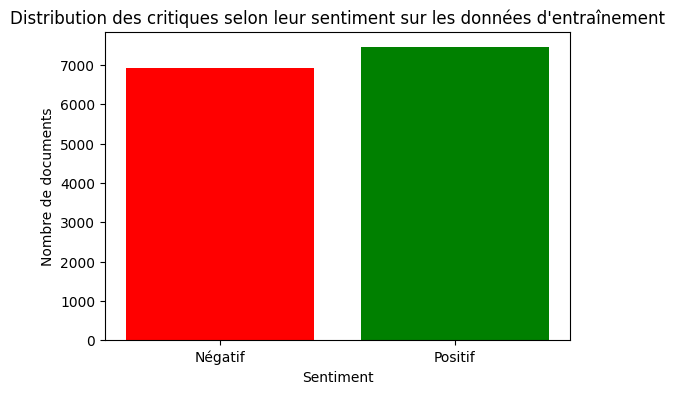

In [39]:


nb_negatifs = len(neg)
nb_positifs = len(pos)

labels = ['Négatif', 'Positif']
counts = [nb_negatifs, nb_positifs]

plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['red', 'green'])
plt.xlabel("Sentiment")
plt.ylabel("Nombre de documents")
plt.title("Distribution des critiques selon leur sentiment sur les données d'entraînement")
plt.show()


## Chargement des données d'entrainement.

Les données d'entrainement sont crées en combinant les données positives et négatives. 
La fonction `word_vector` permet non seulement de charger les données positives et négatives, les charge en listes de mots, mais aussi traite les mots tels que `don t`, `isn t` etc. L'idée est de rechercher tous les pattern qui se termine par `n` suivi par un espace et `t` suivi d'un espace ou de la fin de la chaîne. Ensuite le remplace par une forme contractée. Cette forme contractée sera ensuite transformée sous forme négative en utilisant `contractions`. Par exemple, `don t` sera transformé en `do not`. 

La visualisation des données que nous verrons ultérieurement nous a permis de faire ces traitements.

In [3]:
docs_train = word_vectors(documents_train,docs_pos_train)
# Création des labels
y_train = [0]*len(documents_train) + [1]*len(docs_pos_train)


## Chargement des données de test.

In [4]:


# Construire le chemin relatif par rapport à ce répertoire
folder_path = os.path.join(current_dir, "aclImdb", "test", "neg")
#print(folder_path)


In [5]:
# Chargement des données de test
folder_path = os.path.join(current_dir,"aclImdb","test","neg")
documents_test = input_docs(folder_path)
docs_pos_test=input_docs(os.path.join(current_dir,"aclImdb","test","pos"))
docs_test = word_vectors(documents_test,docs_pos_test)
y_test = [0]*len(documents_test) + [1]*len(docs_pos_test)



In [10]:
print(len(docs_train), len(y_train), len(docs_test), len(y_test))

25000 25000 25000 25000


## Distribution des données de test.

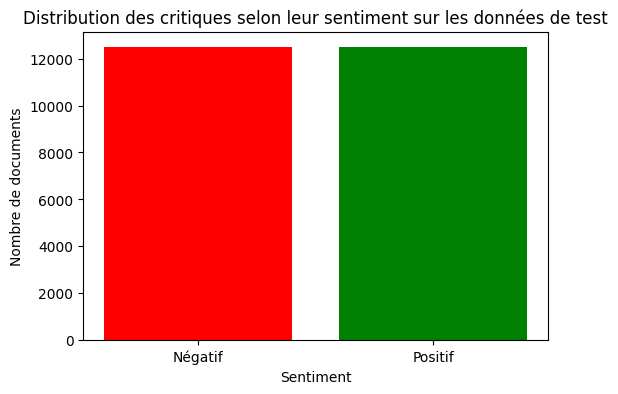

In [38]:

nb_negatifs = len(documents_test)
nb_positifs = len(docs_pos_test)

labels = ['Négatif', 'Positif']
counts = [nb_negatifs, nb_positifs]

plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['red', 'green'])
plt.xlabel("Sentiment")
plt.ylabel("Nombre de documents")
plt.title("Distribution des critiques selon leur sentiment sur les données de test")
plt.show()


## Visualisation des mots de critiques suivant leur fréquence.

Le graphique suivant visualise les mots des critiques négatifs et positifs suivant leur fréquence. Par exemple, les mots `audience`, `source` sont les mots les plus fréquents dans les critiques négatives. Les mots 'Scene`, `Respect` et `lot' sont les mots les plus fréquents dans les critiques positives.

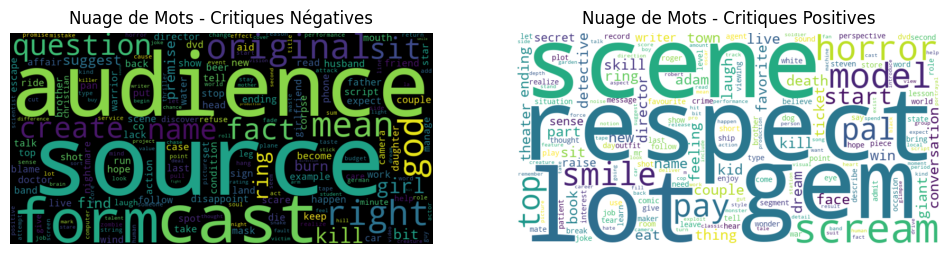

In [12]:

# Générer un word cloud pour les mots négatifs
negative_words = " ".join(neg.keys())  # Concaténer tous les mots négatifs
wordcloud_neg = WordCloud(width=800, height=400, background_color="black").generate(negative_words)

# Générer un word cloud pour les mots positifs
positive_words = " ".join(pos.keys())  # Concaténer tous les mots positifs
wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_words)

# Afficher les word clouds
plt.figure(figsize=(12, 6))

# Word cloud des critiques négatives
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de Mots - Critiques Négatives")

# Word cloud des critiques positives
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de Mots - Critiques Positives")

plt.show()


Une deuxième visualisation permet de vérifier que les éléments qui sont les plus fréquents sont les prépositions, les articles et les pronoms.

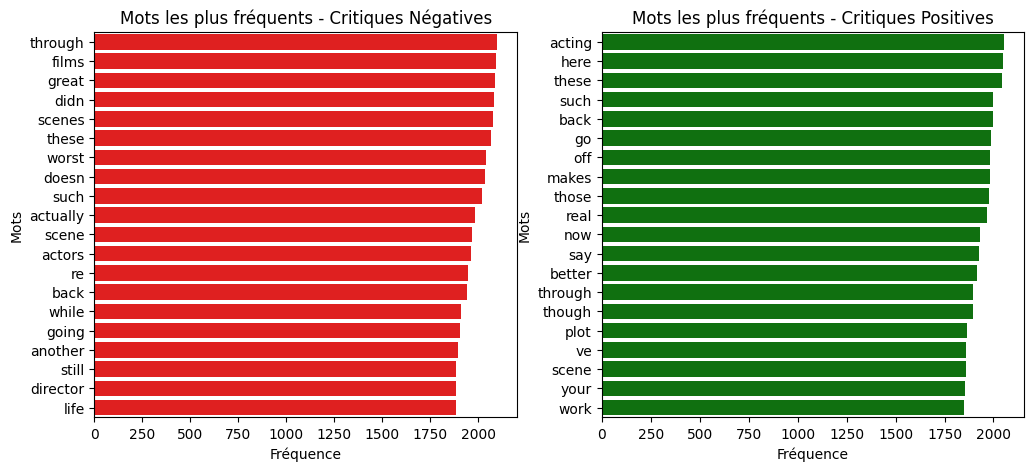

In [13]:


# Trier les mots les plus fréquents
top_neg = sorted(neg.items(), key=lambda x: x[1], reverse=True)[:20]
top_pos = sorted(pos.items(), key=lambda x: x[1], reverse=True)[:20]

# Extraire les données pour l'affichage
words_neg, freq_neg = zip(*top_neg)
words_pos, freq_pos = zip(*top_pos)

# Afficher les histogrammes
plt.figure(figsize=(12, 5))

# Histogramme des mots négatifs
plt.subplot(1, 2, 1)
sns.barplot(x=list(freq_neg), y=list(words_neg), color="red")
plt.xlabel("Fréquence")
plt.ylabel("Mots")
plt.title("Mots les plus fréquents - Critiques Négatives")

# Histogramme des mots positifs
plt.subplot(1, 2, 2)
sns.barplot(x=list(freq_pos), y=list(words_pos), color="green")
plt.xlabel("Fréquence")
plt.ylabel("Mots")
plt.title("Mots les plus fréquents - Critiques Positives")

plt.show()


## Extraction des différentes entités sur l'ensemble des données d'entrainement.

Dans les cellules suivantes, nous allons extraire les entités nommées des chaque token ou mot de chaque critique. Ensuite nous allons visualiser les entités pour évaluer quelles sont les entités pertinentes pour notre analyse de sentiment.

In [17]:
pos_counts, tokens_by_pos = pos_tag_docs(docs_train)


In [18]:
print(pos_counts)
# Counter({'NOUN': 25, 'VERB': 18, 'DET': 15, ...}) par exemple


Counter({'NOUN': 1217453, 'VERB': 738511, 'DET': 639852, 'ADP': 616750, 'PRON': 600417, 'ADJ': 530976, 'AUX': 381997, 'ADV': 374980, 'CCONJ': 229161, 'PROPN': 206571, 'PART': 187087, 'SCONJ': 146380, 'NUM': 35903, 'INTJ': 14828, 'X': 4485, 'PUNCT': 307, 'SYM': 51})


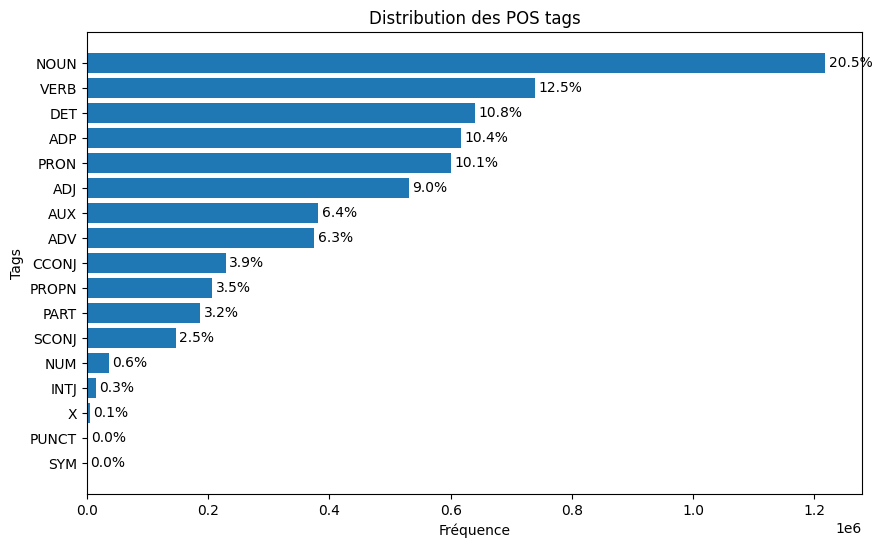

In [20]:


# Récupération des tags et de leurs fréquences, triés par ordre décroissant
tags, freqs = zip(*pos_counts.most_common())
total = sum(freqs)

plt.figure(figsize=(10, 6))
bars = plt.barh(tags, freqs)
plt.xlabel("Fréquence")
plt.ylabel("Tags")
plt.title("Distribution des POS tags")
plt.gca().invert_yaxis()  # Affiche le tag le plus fréquent en haut

# Ajout des pourcentages sur chaque barre
for bar in bars:
    width = bar.get_width()
    percent = width / total * 100
    plt.text(width + total * 0.001, bar.get_y() + bar.get_height()/2,
             f"{percent:.1f}%", va='center', ha='left')

plt.show()


In [21]:
nouns_counter = tokens_by_pos["NOUN"]
print(nouns_counter.most_common(10))
# [('film', 3), ('movie', 3), ('shakespeare', 2), ...] par exemple


[('movie', 43972), ('film', 39786), ('time', 12710), ('story', 11977), ('people', 9295), ('movies', 7651), ('way', 7536), ('characters', 7147), ('character', 6992), ('films', 6774)]


## Exemple : Visualisation des noms les plus fréquents.

La figure suivante montre que le mot le plus fréquent dans les données train est `movie` suivi de `film`. Il faut aussi noté que movie et movies sont considérés comme deux mots différents. Il en est de même pour characters et character. C'est pourquoi nous allons traiter le texte en utilisant une lemmatisation.

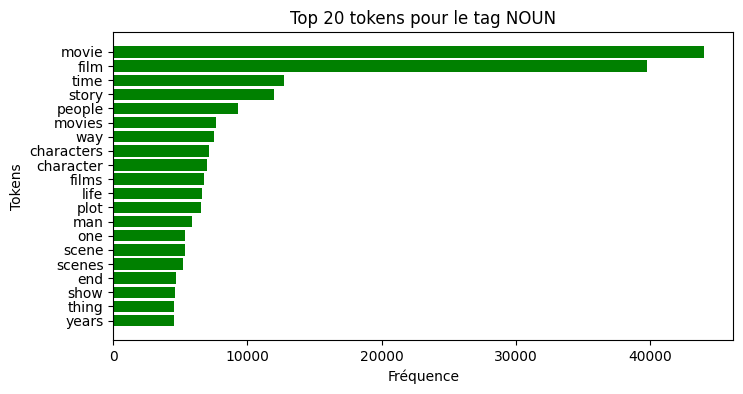

In [22]:


# Exemple : visualiser les noms les plus fréquents
plot_top_tokens_for_tag(tokens_by_pos, "NOUN", top_n=20)


## Lemmatisation des données.

La lemmatisation consiste à transformer les mots en leur forme canonique. Par exemple, les mots `running`, `ran` et `run` seront transformés en `run`. La cellule suivante permet de lemmatiser les données et d'exclure des données les mots qui sont des stop words qui proviennent des entités nommées `SYM`, `PUNCT`, `X`, `AUX`, et `PRON`.

In [ ]:


# Lematization des données d'entraînement

# Préparer la liste de textes en joignant les tokens de chaque document
docs_train_texts = [" ".join(tokens) for tokens in docs_train]

# Utiliser nlp.pipe pour traiter les documents en lots
lemmatized_docs = [None] * len(docs_train_texts)
for i, doc in enumerate(nlp.pipe(docs_train_texts, batch_size=50
                                 ,n_process=4)):
    lemmatized_docs[i] = [token.lemma_ for token in doc if token.pos_ not in {"SYM", "PRON", "X","PUNCT","AUX"}]
    

# 4) Affichage du résultat
for i, (original, lemmatized) in enumerate(zip(docs_train_texts, lemmatized_docs)):
    print(f"Document {i+1}:")
    print("Original :", original)
    print("Lemmatized :", lemmatized)
    print()
    break


Document 1:
Original : working with one of the best shakespeare sources this film manages to be creditable to it s source whilst still appealing to a wider audience branagh steals the film from under fishburne s nose and there s a talented cast on good form
Lemmatized : ['work', 'with', 'one', 'of', 'the', 'good', 'shakespeare', 'source', 'this', 'film', 'manage', 'to', 'creditable', 'to', 's', 'source', 'whilst', 'still', 'appeal', 'to', 'a', 'wide', 'audience', 'branagh', 'steal', 'the', 'film', 'from', 'under', 'fishburne', 's', 'nose', 'and', 's', 'a', 'talented', 'cast', 'on', 'good', 'form']



In [ ]:
# Lematization des données de test

docs_test_texts = [" ".join(tokens) for tokens in docs_test]

# Utiliser nlp.pipe pour traiter les documents en lots
lemmatized_docs_test = [None] * len(docs_test_texts)
for i, doc in enumerate(nlp.pipe(docs_test_texts, batch_size=50, n_process=4)):
    lemmatized_docs_test[i] = [token.lemma_ for token in doc if token.pos_ not in {"SYM", "PRON", "X","PUNCT","AUX"}]
for i, (original, lemmatized) in enumerate(zip(docs_test_texts, lemmatized_docs_test)):
    print(f"Document {i+1}:")
    print("Original :", original)
    print("Lemmatized :", lemmatized)
    print()
    break

Document 1:
Original : alan rickman emma thompson give good performances with southern new orleans accents in this detective flick it s worth seeing for their scenes and rickman s scene with hal holbrook these three actors mannage to entertain us no matter what the movie it seems the plot for the movie shows potential but one gets the impression in watching the film that it was not pulled off as well as it could have been the fact that it is cluttered by a rather uninteresting subplot and mostly uninteresting kidnappers really muddles things the movie is worth a view if for nothing more than entertaining performances by rickman thompson and holbrook
Lemmatized : ['alan', 'rickman', 'emma', 'thompson', 'give', 'good', 'performance', 'with', 'southern', 'new', 'orleans', 'accent', 'in', 'this', 'detective', 'flick', 's', 'worth', 'see', 'for', 'scene', 'and', 'rickman', 's', 'scene', 'with', 'hal', 'holbrook', 'these', 'three', 'actor', 'mannage', 'to', 'entertain', 'no', 'matter', 'the'

In [25]:
pos_counts, tokens_by_pos = pos_tag_docs(lemmatized_docs)

In [26]:
print(pos_counts)
# Counter({'NOUN': 25, 'VERB': 18, 'DET': 15, ...}) par exemple


Counter({'NOUN': 1291535, 'DET': 638777, 'ADP': 621067, 'VERB': 570212, 'ADJ': 539076, 'ADV': 382363, 'PROPN': 240694, 'CCONJ': 229485, 'PART': 189645, 'SCONJ': 126510, 'NUM': 39095, 'AUX': 29948, 'INTJ': 19702, 'PRON': 18750, 'X': 1564, 'PUNCT': 42, 'SYM': 11})


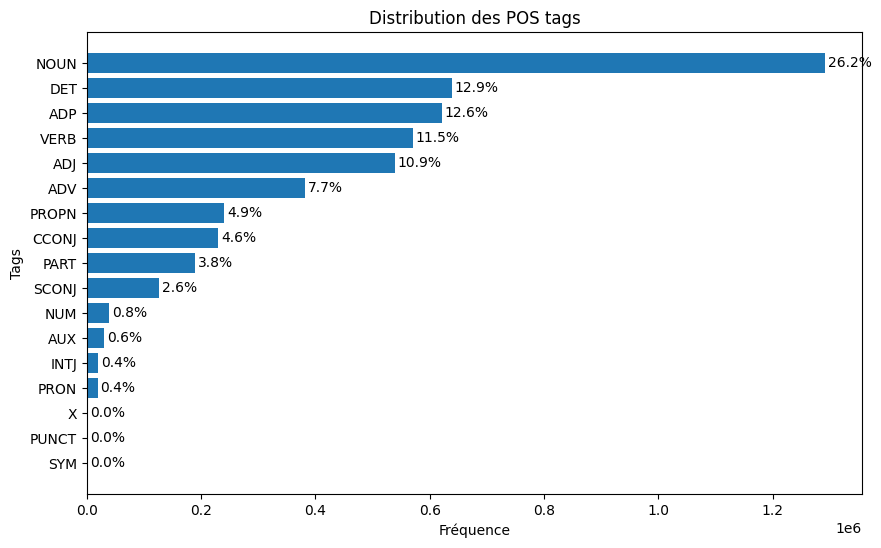

In [27]:


# Extraction des tags et fréquences, triés par ordre décroissant
tags, freqs = zip(*pos_counts.most_common())
total = sum(freqs)

plt.figure(figsize=(10, 6))
bars = plt.barh(tags, freqs)
plt.xlabel("Fréquence")
plt.ylabel("Tags")
plt.title("Distribution des POS tags")
plt.gca().invert_yaxis()  # Le tag le plus fréquent en haut

# Ajouter le pourcentage sur chaque barre
for bar in bars:
    width = bar.get_width()  # La largeur de la barre correspond à la fréquence
    percentage = width / total * 100
    # Placer le texte légèrement à droite de la fin de la barre
    plt.text(width + total * 0.001, bar.get_y() + bar.get_height()/2,
             f"{percentage:.1f}%", va='center', ha='left')

plt.show()


In [28]:
nouns_counter = tokens_by_pos["NOUN"]
print(nouns_counter.most_common(10))
# [('film', 3), ('movie', 3), ('shakespeare', 2), ...] par exemple


[('movie', 51512), ('film', 47335), ('time', 15952), ('character', 14079), ('story', 13137), ('scene', 10506), ('people', 9395), ('way', 8428), ('thing', 8207), ('man', 7798)]


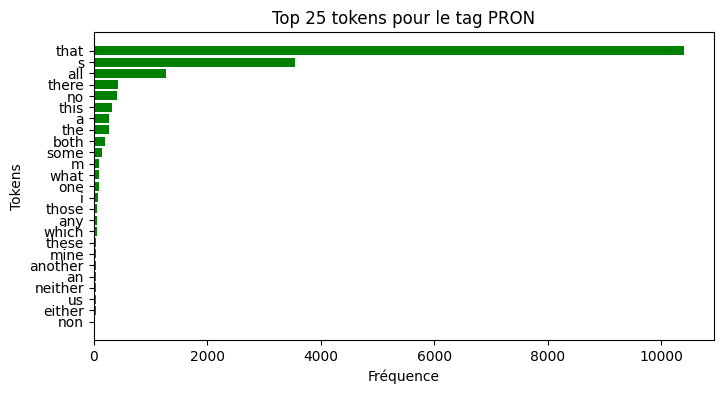

In [29]:


# Exemple : visualiser les noms les plus fréquents
plot_top_tokens_for_tag(tokens_by_pos, "PRON", top_n=25)


## Visualisation des lemme les plus fréquents de chaque entité nommée.

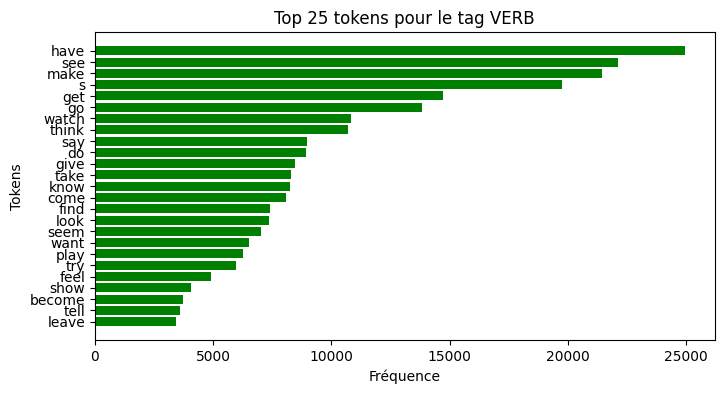

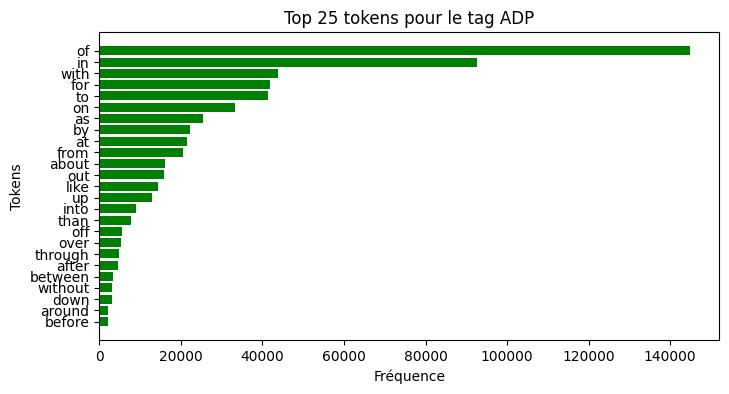

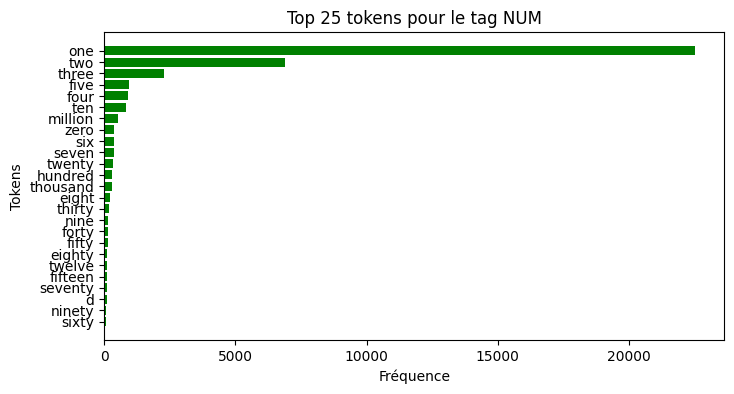

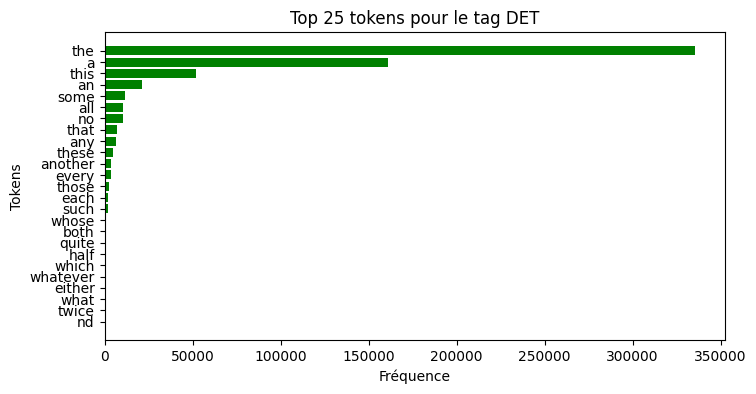

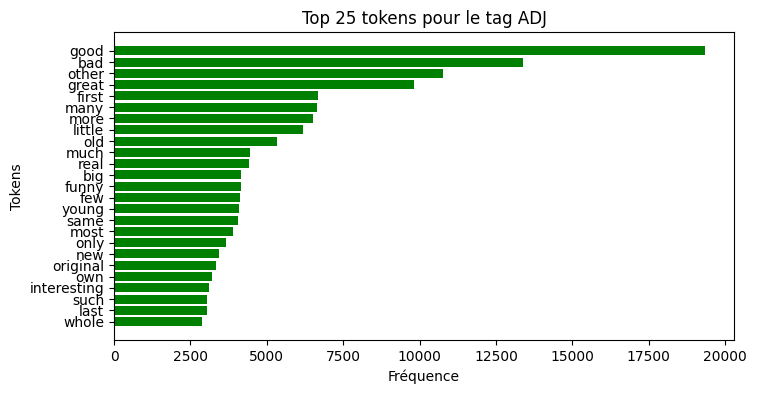

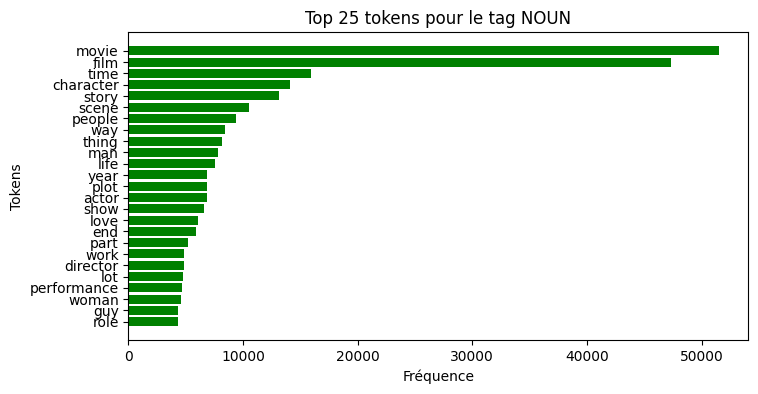

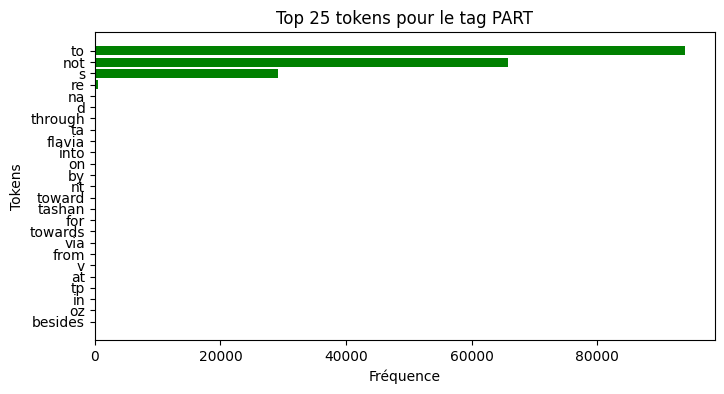

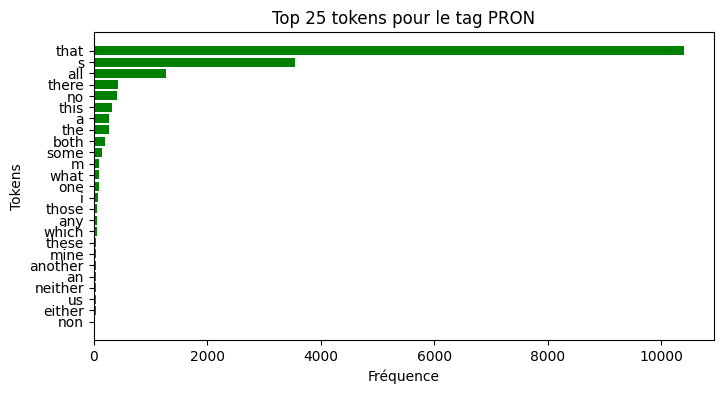

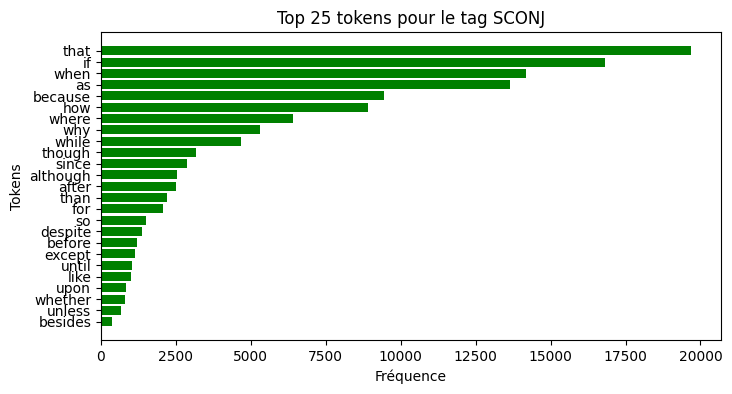

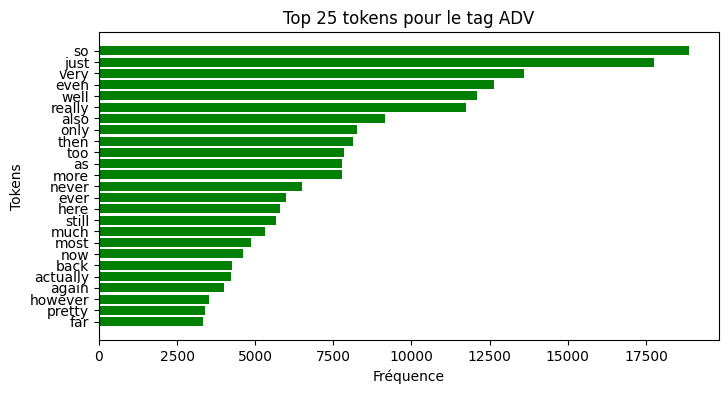

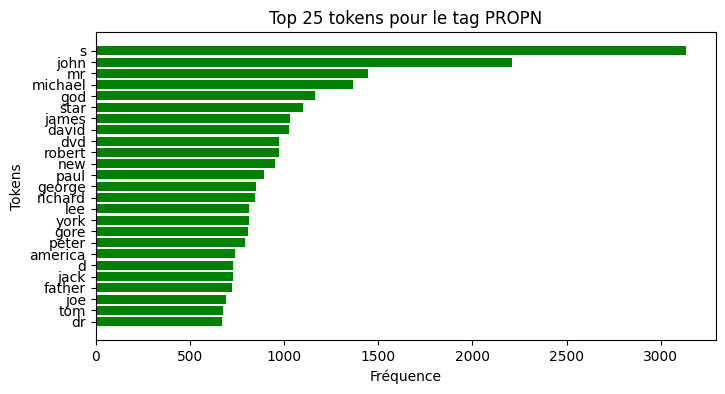

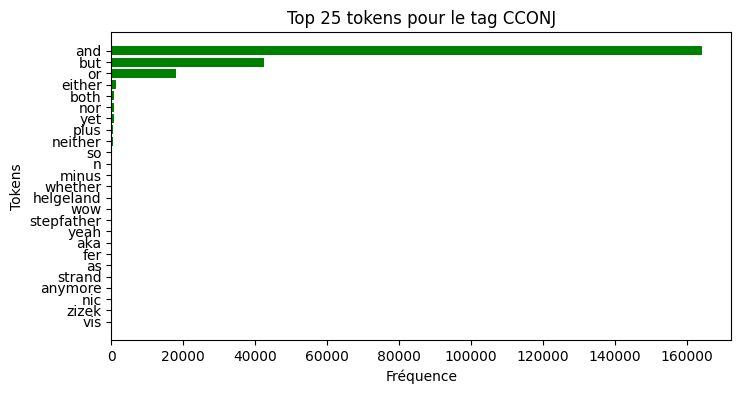

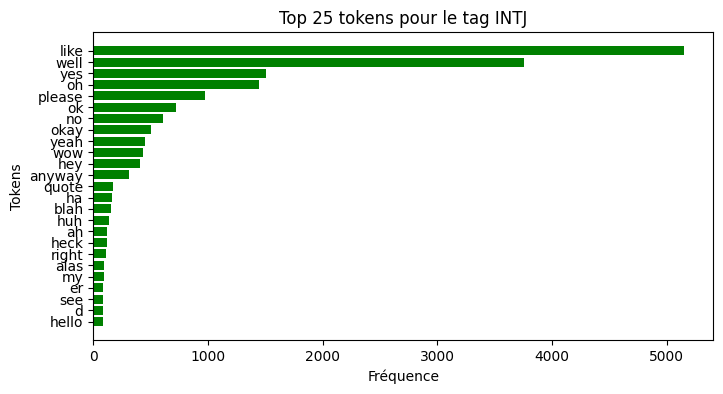

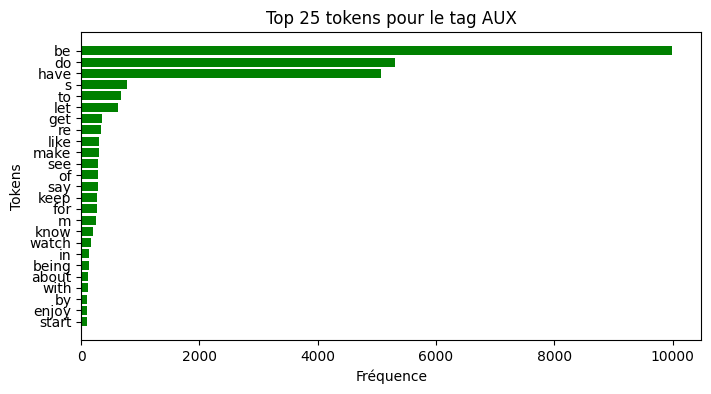

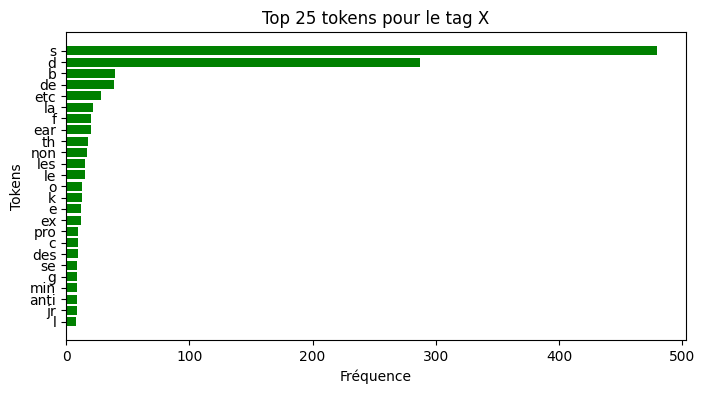

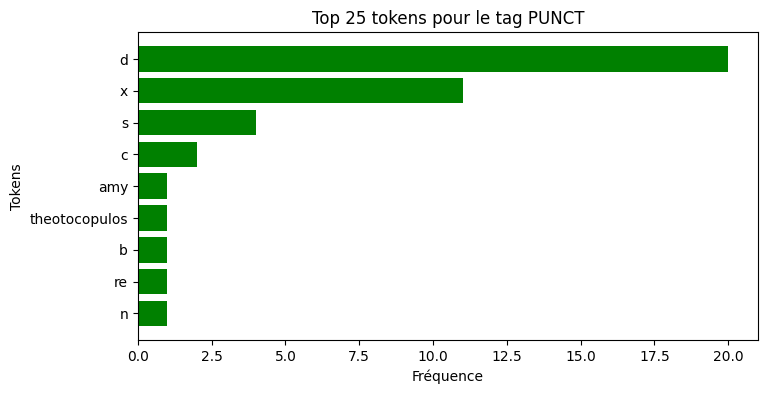

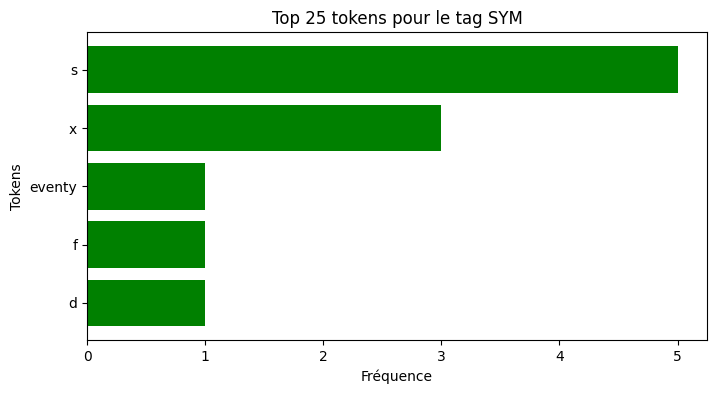

<Figure size 640x480 with 0 Axes>

In [31]:


# Récupérer la liste des tags (ici 17 tags)
tags = list(tokens_by_pos.keys())


# Tracer les 16 premiers tags dans les 4 premières lignes
for i in range(16):
    
    tag = tags[i]
    # On suppose que plot_top_tokens_for_tag accepte un paramètre ax
    plot_top_tokens_for_tag(tokens_by_pos, tag, top_n=25)
   
tag = tags[16]
plot_top_tokens_for_tag(tokens_by_pos, tag, top_n=25)

plt.tight_layout()
plt.show()


## Analyse de sentiment.

Dans cette partie, nous allons procéder à l'analyse de sentiment. Nous allons utiliser les mèthodes traditionnelles de machine learning telles que Naive Bayes, SVM, Random Forest et XGBoost. Et une méthode de Large Language Model, BERT.

Pour les méthodes de machines learning classique, il faut trouver une représentation des mots, token ou lemme. Nous allons utiliser une première méthode qui consiste à utiliser les fréquences des mots appelée tf-idf. Cette méthode ne prend pas en compte l'ordre des mots, la polysémie des mots. En plus, elle est sparse et peut augmenter la complexité de stockage et de calcul. Nous allons utiliser une deuxième méthode word2vec qui est une méthode `embedding`. Contrairement à tf-idf, word2vec représente les mots sous forme de vecteurs de dimensions entre 50 et 1000, qui sont des vecteurs denses: les valeurs de ces vecteurs sont des réels qui peuvent être positifs ou négatifs.

### tf-idf

Cette représentation permet une représentation sous forme matricielle. Chaque ligne représente un mot ou token ou lemme et chaque colonne représente un document. La valeur de chaque cellule est la fréquence du mot pondérée par l'inverse de la fréquence du mot dans le corpus. La représentation du mot est donnée par la formule suivante :

$$
\text{tf}_{t,d} = 
\begin{cases}
1 + \log_{10}(\text{count}(t,d)), & \text{si } \text{count}(t,d) > 0,\\
0, & \text{sinon}.
\end{cases}
$$
où $\text{count}(t,d)$ est le nombre d'occurrences du mot $t$ dans le document $d$ et $log_{10}$ est le logarithme en base 10.

L’idée est que compter un mot (disons, 100 fois) dans un document ne rend pas ce mot proportionnellement plus important pour caractériser le sens du document. En d’autres termes, si un mot apparaît énormément, ce n’est pas forcément parce qu’il est sémantiquement central à la thématique. C’est plutôt que ce mot peut être très commun ou contextuel. C’est pourquoi on utilise une pondération comme la fonction logarithmique — pour réduire l’impact des mots apparaissant très fréquemment et ne pas leur donner un poids démesuré dans la représentation du document.

Dans la cellule  suivante, nous utilisons les pipelines pour entrainer les modèles de machine learning. L'entrainement se fait en trois étapes :

- Transformation des mots token ou lemme en supprimant les tags `SYM`, `PUNCT`, `X`, `AUX`, et `PRON`.
- Transformation des mots en vecteurs en utilisant la méthode tf-idf.
- Entrainement des modèles de machine learning (Naive Bayes, Régression logistique, Régression logistique avec régularisation, SVM, XGBoost).

In [7]:


# Charger spaCy et désactiver les composants non nécessaires pour accélérer le traitement
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])




# Vous pouvez ensuite intégrer ce transformateur dans votre pipeline.
pipeline_with_nb= Pipeline([
    ('lemmatizer', Lemmatizer(batch_size=50, n_process=4, excluded_tags={"SYM", "PRON", "X","PUNCT","AUX"})),
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])



pipeline_with_lr = Pipeline([
    ('lemmatizer', Lemmatizer(batch_size=50, n_process=4, excluded_tags={"SYM", "PRON", "X","PUNCT","AUX"})),
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

pipeline_with_svm = Pipeline([
    ('lemmatizer', Lemmatizer(batch_size=50, n_process=4, excluded_tags={"SYM", "PRON", "X","PUNCT","AUX"})),
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())
])

pipeline_with_xgb = Pipeline([
    ('lemmatizer', Lemmatizer(batch_size=50, n_process=4, excluded_tags={"SYM", "PRON", "X","PUNCT","AUX"})),
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier(
    objective='binary:logistic', # classification binaire
    seed=12345,
    gamma=0,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    eval_metric='logloss'
))
])

# ElasticNetCV

pipeline_with_elasticnet = Pipeline([
    ('lemmatizer', Lemmatizer(batch_size=50, n_process=4, excluded_tags={"SYM", "PRON", "X","PUNCT","AUX"})),
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegressionCV(penalty='elasticnet', l1_ratios=[0.5], 
                                   cv=5, 
                                 solver="saga",tol=0.01, random_state=12345))
])




In [9]:
# Entraîner le modèle
pipeline_with_nb.fit(docs_train, y_train)
pipeline_with_lr.fit(docs_train, y_train)
pipeline_with_svm.fit(docs_train, y_train)

Pipeline(steps=[('lemmatizer',
                 Lemmatizer(excluded_tags={'PUNCT', 'AUX', 'SYM', 'X', 'PRON'},
                            n_process=4)),
                ('tfidf', TfidfVectorizer()), ('clf', SVC())])

In [10]:
# Train xgb

pipeline_with_xgb.fit(docs_train, y_train)

Pipeline(steps=[('lemmatizer',
                 Lemmatizer(excluded_tags={'PUNCT', 'AUX', 'SYM', 'X', 'PRON'},
                            n_process=4)),
                ('tfidf', TfidfVectorizer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               fe...ghts=None,
                               gamma=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [8]:
# Train elasticnet

pipeline_with_elasticnet.fit(docs_train, y_train)


Pipeline(steps=[('lemmatizer',
                 Lemmatizer(excluded_tags={'PUNCT', 'AUX', 'SYM', 'X', 'PRON'},
                            n_process=4)),
                ('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegressionCV(cv=5, l1_ratios=[0.5],
                                      penalty='elasticnet', random_state=12345,
                                      solver='saga', tol=0.01))])

In [15]:
# Prédire les étiquettes
y_pred_nb = pipeline_with_nb.predict(docs_test)
y_pred_lr = pipeline_with_lr.predict(docs_test)
y_pred_svm = pipeline_with_svm.predict(docs_test)

In [11]:
# predict xgb and elasticnet
y_pred_xgb = pipeline_with_xgb.predict(docs_test)
y_pred_elasticnet = pipeline_with_elasticnet.predict(docs_test)

### Evaluation des performances du modèle.

La fonction `evaluate_model` permet d'évaluer les performances des modèles en utilisant les métriques suivantes : précision, rappel, F1-score.

In [16]:
# Évaluer les modèles
evaluate_model("Naive Bayes", y_test, y_pred_nb)
evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("SVM", y_test, y_pred_svm)
evaluate_model("XGB", y_test, y_pred_xgb)
evaluate_model("ElasticNet", y_test, y_pred_elasticnet)


--- Naive Bayes ---
Accuracy : 0.82408
Precision: 0.8658778901734104
Recall   : 0.76696
F1-score : 0.8134227049041235

--- Logistic Regression ---
Accuracy : 0.8788
Precision: 0.876930425091546
Recall   : 0.88128
F1-score : 0.8790998324156093

--- SVM ---
Accuracy : 0.88044
Precision: 0.8828596731342082
Recall   : 0.87728
F1-score : 0.8800609927370491

--- XGB ---
Accuracy : 0.82408
Precision: 0.803900975243811
Recall   : 0.85728
F1-score : 0.829732868757259

--- ElasticNet ---
Accuracy : 0.8774
Precision: 0.8771887742863996
Recall   : 0.87768
F1-score : 0.8774343183908505


Les modèle SVM, Régression logistique ElasticNet ont les performances similaires. Et ils sont les meilleurs modèles pour la méthode tf-idf. Le xgboost et Naive Bayes ont des performances moins bonnes que les deux premiers modèles.

### Courbe de ROC et AUC.

In [39]:

pipelines = {
    'Naive Bayes': pipeline_with_nb,
    'Logistic Regression': pipeline_with_lr,
    'SVM': pipeline_with_svm,
    'XGBoost': pipeline_with_xgb,
    'ElasticNetCV': pipeline_with_elasticnet
}


roc_results = compute_roc(pipelines, docs_test, y_test)

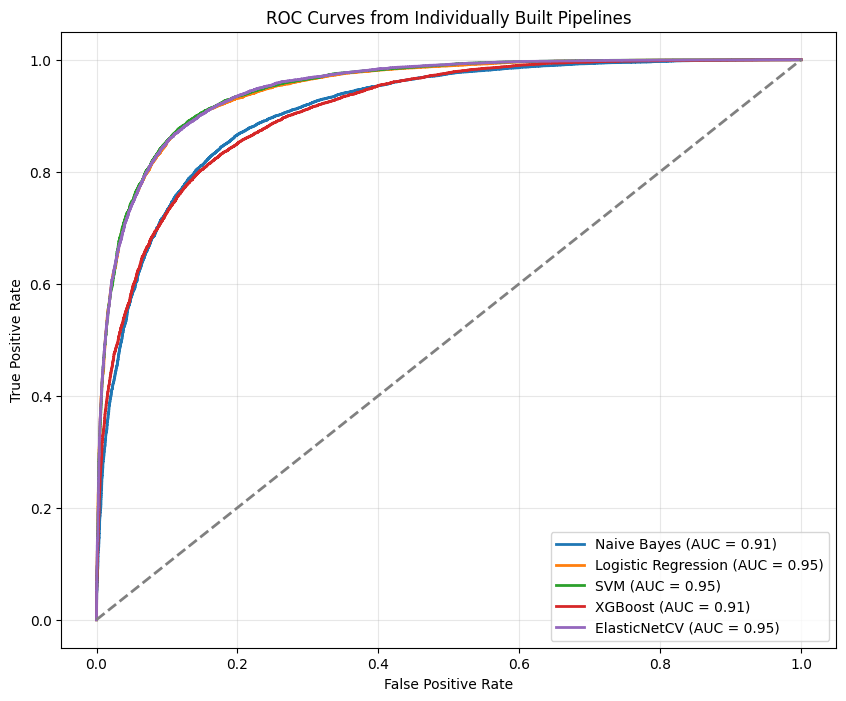

In [40]:
plt.figure(figsize=(10, 8))

for name, roc in roc_results.items():
    plt.plot(
        roc['fpr'], roc['tpr'],
        lw=2, label=f'{name} (AUC = {roc["roc_auc"]:.2f})'
    )

# ligne diagonale aléatoire
plt.plot([0, 1], [0, 1], '--', color='gray', lw=2)

# Labels et titre
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves from Individually Built Pipelines')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Word2Vec

Les embeddings Word2vec sont des **embeddings statiques**, ce qui signifie que la méthode apprend **une représentation (embedding) fixe pour chaque mot** dans le vocabulaire d’embeddings statiques. Il utilise l'algorithme Skip-gram pour apprendre les embeddings :

1. Considérer le mot cible et un mot de contexte voisin comme des exemples positifs.  
2. Échantillonner aléatoirement d’autres mots dans le lexique pour obtenir des échantillons négatifs.  
3. Utiliser la régression logistique pour entraîner un classifieur à distinguer ces deux cas.  
4. Utiliser les poids appris comme embeddings.



In [6]:
          
def lemmatizProcess(docs, excluded_tags=None):
    
    excluded_set = set(excluded_tags) if excluded_tags else set()
    
    # Préallouer le résultat avec la bonne taille
    lemmatized_docs = [None] * len(docs)
    
    # Si les documents sont déjà tokenisés mais nécessitent un traitement spaCy
    docs_text = [" ".join(doc) for doc in docs]
    
    # Traiter les documents avec plus de processus si possible
    for i, doc in enumerate(nlp.pipe(docs_text, batch_size=50, n_process=-1)):
        # Filtrer les tokens dont le pos tag est dans excluded_set
        lemmatized = [token.lemma_ for token in doc if token.pos_ not in excluded_set]
        lemmatized_docs[i] = lemmatized
    
    return lemmatized_docs
    

In [7]:
X_train_lemmatized = lemmatizProcess(docs_train, excluded_tags={"SYM", "PUNCT", "X","PRON","AUX"})
X_test_lemmatized = lemmatizProcess(docs_test, excluded_tags={"SYM", "PUNCT", "X","PRON","AUX"})

In [8]:
# Model word2vec

model = Word2Vec(sentences=X_train_lemmatized, vector_size=100, window=5, min_count=1, workers=4)

In [9]:


X_train_word2vec = np.array([document_vector(doc, model) for doc in X_train_lemmatized])
X_test_word2vec = np.array([document_vector(doc, model) for doc in X_test_lemmatized])

In [10]:
# import GaussianNB
from sklearn.naive_bayes import GaussianNB
# Naive Bayes
nb_model = GaussianNB()

# Régression Logistique
lr_model = LogisticRegression(max_iter=1000)

# SVM (linéaire)
svm_model = SVC(kernel='linear')

# XGBoost

xgb_model = XGBClassifier(
    objective='binary:logistic',
    seed=12345,
    gamma=0,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    eval_metric='logloss'
)

# ElasticNetCV

elasticnet_model = LogisticRegressionCV(penalty='elasticnet', l1_ratios=[0.5], 
                                   cv=5, 
                                 solver="saga",tol=0.01, random_state=12345)





In [11]:
nb_model.fit(X_train_word2vec, y_train)
lr_model.fit(X_train_word2vec, y_train)
svm_model.fit(X_train_word2vec, y_train)
xgb_model.fit(X_train_word2vec, y_train)
elasticnet_model.fit(X_train_word2vec, y_train)

LogisticRegressionCV(cv=5, l1_ratios=[0.5], penalty='elasticnet',
                     random_state=12345, solver='saga', tol=0.01)

In [12]:
y_pred_nb = nb_model.predict(X_test_word2vec)
y_pred_lr = lr_model.predict(X_test_word2vec)
y_pred_svm = svm_model.predict(X_test_word2vec)
y_pred_xgb = xgb_model.predict(X_test_word2vec)
y_pred_elasticnet = elasticnet_model.predict(X_test_word2vec)


In [13]:
evaluate_model("Naive Bayes", y_test, y_pred_nb)
evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("SVM", y_test, y_pred_svm)
evaluate_model("XGB", y_test, y_pred_xgb)
evaluate_model("ElasticNet", y_test, y_pred_elasticnet)




--- Naive Bayes ---
Accuracy : 0.67824
Precision: 0.6913760522247037
Recall   : 0.64392
F1-score : 0.6668047386297739

--- Logistic Regression ---
Accuracy : 0.80516
Precision: 0.8042593921990907
Recall   : 0.80664
F1-score : 0.8054479370531613

--- SVM ---
Accuracy : 0.80584
Precision: 0.804524454357177
Recall   : 0.808
F1-score : 0.8062584816795721

--- XGB ---
Accuracy : 0.78828
Precision: 0.7904408801483034
Recall   : 0.78456
F1-score : 0.7874894607941543

--- ElasticNet ---
Accuracy : 0.80568
Precision: 0.8068583360102795
Recall   : 0.80376
F1-score : 0.805306187880731


In [15]:

models = {
    'Naive Bayes': nb_model,
    'Logistic Regression': lr_model,
    'SVM': svm_model,
    'XGBoost': xgb_model,
    'ElasticNetCV': elasticnet_model
}


roc_results_word2vec = compute_roc(models, X_test_word2vec, y_test)

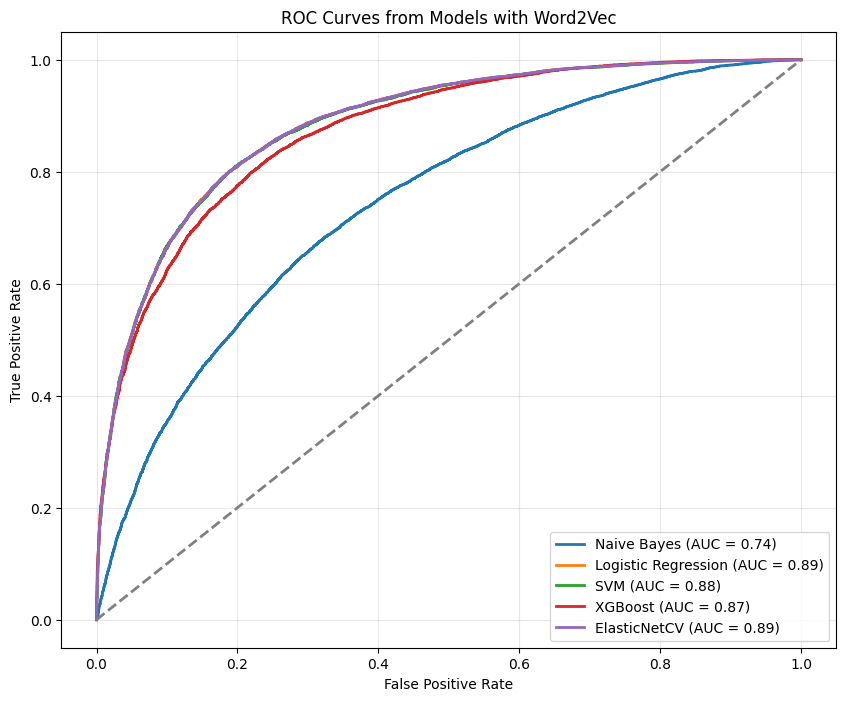

In [16]:
plt.figure(figsize=(10, 8))

for name, roc in roc_results_word2vec.items():
    plt.plot(
        roc['fpr'], roc['tpr'],
        lw=2, label=f'{name} (AUC = {roc["roc_auc"]:.2f})'
    )

# ligne diagonale aléatoire
plt.plot([0, 1], [0, 1], '--', color='gray', lw=2)

# Labels et titre
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves from Models with Word2Vec')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


## Large Language Model : BERT

C’est un modèle de transformeur bidirectionnel pré-entraîné. Son entraînement repose sur le **masked language modeling** : au lieu de prédire le mot suivant, on masque un mot au milieu de la phrase et on demande au modèle de le deviner en se basant à la fois sur les mots à gauche et à droite. Ainsi, le modèle peut tenir compte du contexte de chaque côté.

La puissance des modèles de langage pré-entraînés réside dans leur capacité à extraire des généralisations à partir de grandes quantités de texte – des généralisations utiles pour toute une variété d’applications ultérieures.

Il peut être utilisé pour les classifications séquentielles qui consiste à classifier une séquence de mots en une seule catégorie. Donc peut être utilisé pour la classification de sentiment.

In [17]:


X_train_Bert = documents_train+docs_pos_train

X_test_Bert = documents_test+docs_pos_test



In [18]:
from transformers import BertTokenizer, BertForSequenceClassification


#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [14]:

max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(X_train_Bert,
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='pt')



X_test_encoded = tokenizer.batch_encode_plus(X_test_Bert, 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='pt')


In [15]:

k = 0
print('Training Comments -->>',X_train_Bert[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',y_train[k])


Training Comments -->> working with one of the best shakespeare sources this film manages to be creditable to it s source whilst still appealing to a wider audience branagh steals the film from under fishburne s nose and there s a talented cast on good form

Input Ids -->>
 tensor([  101,  2551,  2007,  2028,  1997,  1996,  2190,  8101,  4216,  2023,
         2143,  9020,  2000,  2022,  4923,  3085,  2000,  2009,  1055,  3120,
         5819,  2145, 16004,  2000,  1037,  7289,  4378, 24905, 17988, 15539,
         1996,  2143,  2013,  2104,  3869,  8022,  2063,  1055,  4451,  1998,
         2045,  1055,  1037, 10904,  3459,  2006,  2204,  2433,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  

In [16]:


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 2) Récupérer les tenseurs
train_input_ids = X_train_encoded["input_ids"]          # shape: (N, max_len)
train_attention_mask = X_train_encoded["attention_mask"]
train_labels = torch.tensor(y_train)                    # labels shape: (N,)

# 3) Créer le dataset PyTorch
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)

# 4) DataLoader
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [27]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

model.train()
for batch in train_loader:
    optimizer.zero_grad()
    
    # Décompresse le batch
    input_ids, attention_mask, labels = batch

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels
    )
    # outputs.loss est la loss calculée
    loss = outputs.loss

    loss.backward()
    optimizer.step()


In [28]:

test_input_ids = X_test_encoded["input_ids"]
test_attention_mask = X_test_encoded["attention_mask"]
test_labels = torch.tensor(y_test)

test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)


In [29]:
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [30]:
import torch

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Choisir la classe prédite
        predictions = torch.argmax(logits, dim=1)
        
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convertir en numpy
y_pred = np.array(all_preds)
y_true = np.array(all_labels)


In [33]:
# Évaluer le modèle

evaluate_model("BERT", y_true, y_pred)


--- BERT ---
Accuracy : 0.8886
Precision: 0.8938619962701695
Recall   : 0.88192
F1-score : 0.887850843635485
